In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re
from utils import *
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import homogeneity_score
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/U.S._Chronic_Disease_Indicators__CDI_.csv")
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2015,2015,US,United States,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,59,ALC,ALC8_0_2,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
1,2012,2012,DC,District of Columbia,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,11,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
2,2012,2012,GU,Guam,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,66,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2012,2012,PR,Puerto Rico,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,72,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN
4,2012,2012,US,United States,APIS,Alcohol,Amount of alcohol excise tax by beverage type ...,NaN,$,US Dollars,...,59,ALC,ALC8_0_1,USD,OVERALL,OVR,NaN,NaN,NaN,NaN


# Keep only the unique questions

In [3]:
df = df[~df.duplicated("Question", keep="first")][["Topic", "Question"]].reset_index(drop=True)
df.head()

,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...


# Breakdown of questions' topics

In [4]:
topics = df["Topic"].value_counts()
topics

Nutrition, Physical Activity, and Weight Status    37
Cancer                                             20
Diabetes                                           20
Cardiovascular Disease                             18
Alcohol                                            16
Tobacco                                            16
Overarching Conditions                             16
Chronic Obstructive Pulmonary Disease              16
Arthritis                                          10
Asthma                                              9
Oral Health                                         9
Chronic Kidney Disease                              4
Older Adults                                        4
Reproductive Health                                 3
Mental Health                                       3
Immunization                                        1
Disability                                          1
Name: Topic, dtype: int64

# Filter out categories with few entries

In [5]:
df = df[df["Topic"].str.match("|".join(topics.nlargest(11).index.to_list()))].reset_index(drop=True)
df.head()

,Topic,Question
0,Alcohol,Amount of alcohol excise tax by beverage type ...
1,Alcohol,Amount of alcohol excise tax by beverage type ...
2,Alcohol,Amount of alcohol excise tax by beverage type ...
3,"Nutrition, Physical Activity, and Weight Status",Obesity among adults aged >= 18 years
4,Cardiovascular Disease,Hospitalization for heart failure among Medica...


# Convert questions to embeddings

In [6]:
_, __, word_to_vec = read_glove_vecs("GloVe/glove.6B.200d.txt")

In [7]:
unk = np.zeros(word_to_vec["a"].shape)
for emb in word_to_vec.values():
    unk += emb
unk = unk / len(word_to_vec)
word_to_vec["<unk>"] = unk

In [8]:
def question_to_vec(question):
    split = lambda x: re.findall(r"[\w']+|[.,!?;]", x.lower()) if x is not None else []
    embedding = np.zeros(word_to_vec["a"].shape)
    words = split(question)
    for word in words:
        if word in word_to_vec:
            embedding += word_to_vec[word]
        else:
            embedding += word_to_vec["<unk>"]
    return embedding/len(words)
embeddings = df["Question"].apply(question_to_vec).to_list()

# Reduce dimensionality

In [9]:
pca_2d = PCA(n_components=2)
coords = pca_2d.fit_transform(embeddings)
coords.shape

(187, 2)

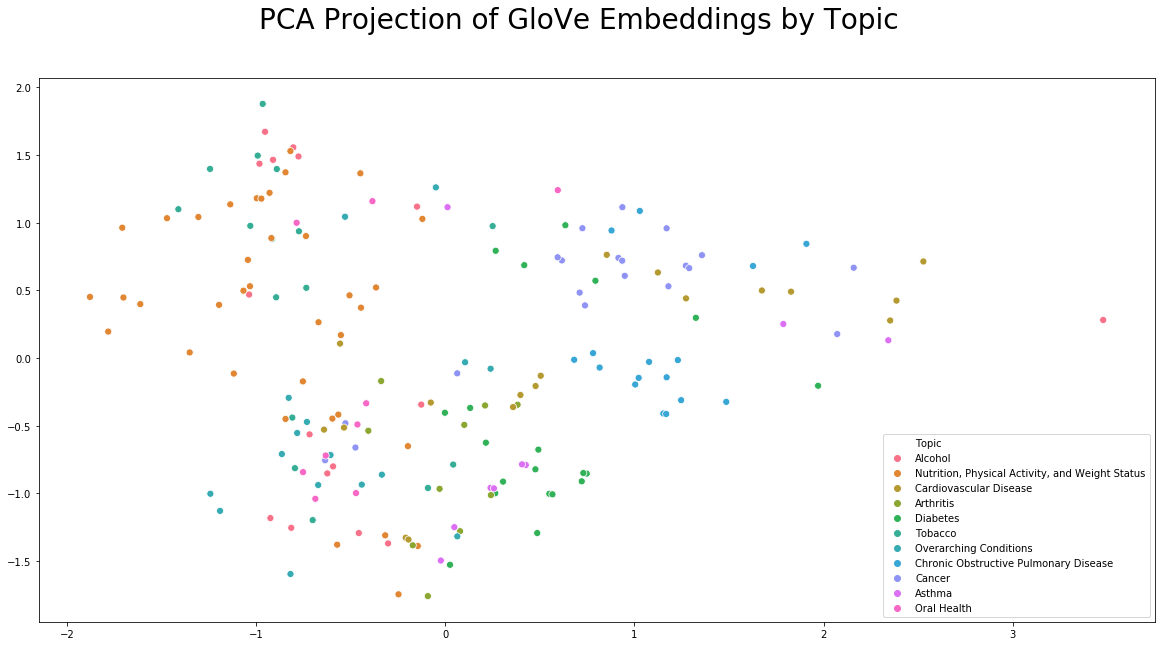

In [10]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("PCA Projection of GloVe Embeddings by Topic", fontsize=28)
sns.scatterplot(coords[:,0], coords[:,1], hue=df["Topic"], s=50)

In [22]:
tsne = TSNE(n_components=2)
coords = tsne.fit_transform(embeddings)
coords.shape

(187, 2)

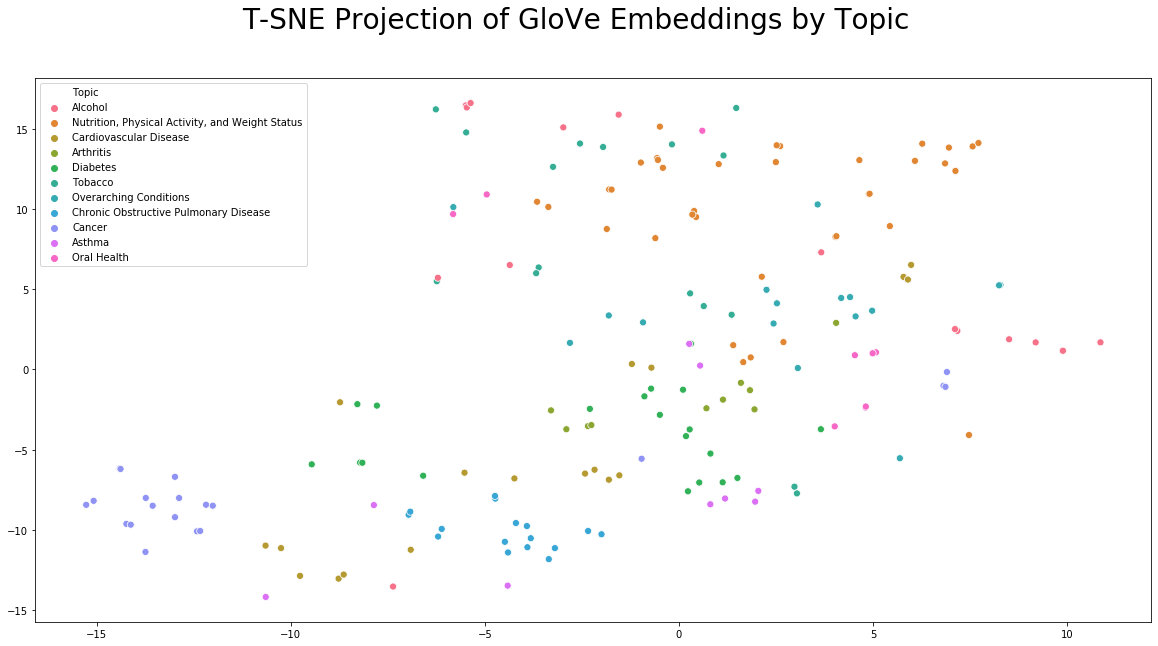

In [23]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("T-SNE Projection of GloVe Embeddings by Topic", fontsize=28)
sns.scatterplot(coords[:,0], coords[:,1], hue=df["Topic"], s=50)

In [25]:
projection = df[["Question", "Topic"]].rename(columns=lambda s:s.lower())
projection["x"] = coords[:,0]
projection["y"] = coords[:,1]
projection["topic"] = df["Topic"]
projection.to_csv("projections/GloVe.csv", index=False)

In [11]:
pca = PCA(n_components=25)
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'variance')

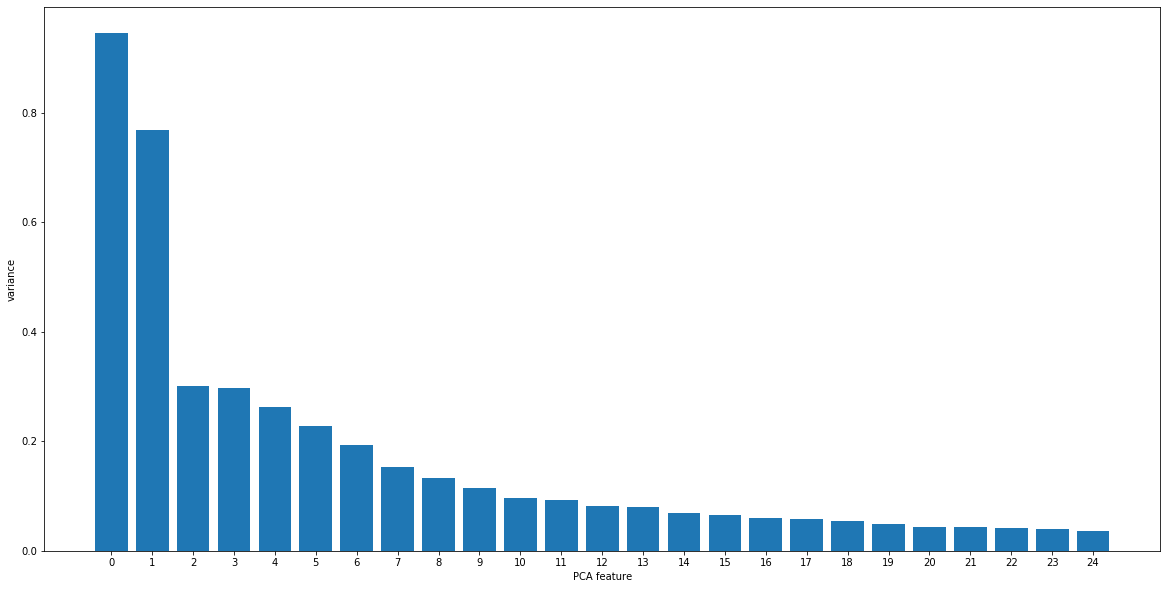

In [12]:
features = range(pca.n_components_)
plt.figure(figsize=(20, 10))
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA feature')
plt.ylabel('variance')

In [13]:
"""
distribution = []
for j in range(100):
    avg_params 
    params = pd.DataFrame(columns=["# of components", "Inertia", "Homogeneity Score"])
    for i in range(1, 26):
        pca = PCA(n_components=i)
        kmeans = KMeans(n_clusters=11)
        steps = [("pca", pca), ("kmeans", kmeans)]
        pipeline = Pipeline(steps)
        pipeline.fit(embeddings)
        params.loc[i-1] = [i, kmeans.inertia_, homogeneity_score(df["Topic"], pipeline.predict(embeddings))]
    distribution.append(params["Homogeneity Score"].idxmax())
"""
None

In [ ]:
plt.xticks(range(5, 25))
plt.hist(distribution)

In [ ]:
pca = PCA(n_components=10)
kmeans = KMeans(n_clusters=11)
steps = [("pca", pca), ("kmeans", kmeans)]
pipeline = Pipeline(steps)
pipeline.fit(embeddings)

In [ ]:
df["cluster"] = pipeline.predict(embeddings)
df